In [1]:
# Python standard library
import os, sys

# Data
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from PIL import Image

# Machine learning
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# Utils
sys.path.append(".")
from utils import classification_metrics as cmetrics
from utils import finger_prints as fp
from utils import classification_workflow_functions as cwf

import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.ERROR)

from dask.distributed import Client
try:
    client.shutdown()
except NameError:
    log.info("No client already active")

client = Client(dashboard_address=":8855")
log.info("Dask clinet on localhost:8855")

random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed} current working dir {os.getcwd()}")

/Users/matina/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.makedirs("results_ccus_fingerprints", exist_ok=True)
os.chdir("results_ccus_fingerprints")

# Prepare data

## Load

In [81]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [82]:
data = pd.read_csv("../data/ccs-98.csv", sep=";")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [83]:
smiles = data["smiles"]
log.info("SMILES: {}".format(smiles.head()))

names = data["label"]
log.info("Names: {}".format(names.head()))

number_of_n_atoms = data["n_nitrogen"].astype("int")
log.info("Number of N atoms: {}".format(number_of_n_atoms.head()))

amines_mass_mr = data["molecular_mass"].astype("float64")
pd.to_numeric(amines_mass_mr, errors="coerce")
log.info("Amines mass Mr: {}".format(amines_mass_mr.head()))

molco2_moln = data["capacity_molco2_molamime"]
pd.to_numeric(molco2_moln, errors="coerce")
log.info("molCO2_molN: {}".format(molco2_moln.head()))

initial_rates = data["rate_molco2_molamime_min"]
pd.to_numeric(initial_rates, errors="coerce")
log.info("initial_rates: {}".format(initial_rates.head()))

## Set Target Properties

In [85]:
targets = molco2_moln
target_name = "capacity (molCO2 / molN)"
target_key = "capacity_molco2_molamime"
units = "molco2_moln"

## Compute Features

In [86]:
ccusfp = fp.ccus_fps(fingerprint_version=2)
df_information = ccusfp.get_fp_information(return_df=True)

In [87]:
features, features_df, smarts = fp.ccs_fp(smiles, version=2)
features_fp_df = pd.DataFrame(data=np.array(["".join([str(i) for i in row.values]) for index, row in features_df.iterrows()]).T, columns=["ccs_fingerprints"])
log.info(features_df)
feature_types = "catagorical" # other options 'some_catagorical', 'no_catagorical'

In [88]:
len(features_df.columns)

72

In [89]:
client.close()

## Compute classes

In [90]:
counts = []
for ith, s in enumerate(smiles):
    n_primary, n_secondary, n_tertiary, n_aromaticsp2 = cwf.count_amine_types(s, show=False)
    counts.append([n_primary, n_secondary, n_tertiary, n_aromaticsp2])

df = pd.DataFrame(data=counts, columns=["primary_amine_counts","secondary_amine_counts", "tertiary_amine_counts", "aromatic_sp2_n" ])
df.corr()

,primary_amine_counts,secondary_amine_counts,tertiary_amine_counts,aromatic_sp2_n
primary_amine_counts,1.000000,0.169055,0.169133,-0.089662
secondary_amine_counts,0.169055,1.000000,0.041569,-0.121115
tertiary_amine_counts,0.169133,0.041569,1.000000,-0.162201
aromatic_sp2_n,-0.089662,-0.121115,-0.162201,1.000000


In [91]:
if target_name == "initial_rate":
    log.info("Initial rate class")
    mean = np.mean(initial_rates)
    stdev = np.std(initial_rates)
    class_thresh = mean + stdev
    log.info("mean {} standard deviation {} class threshold {}".format(mean, stdev, class_thresh))
    classes = []
    for i in initial_rates:
        if i < class_thresh:
            classes.append(0)
        else:
            classes.append(1)
    log.info("Number of classes: {}  Number of class 1: {} number of class 0: {}".format(len(classes), len([x for x in classes if x == 1]), len([x for x in classes if x == 0])))
    class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
    features_and_classes_df = features_df.copy()
    features_and_classes_df["classes"] = classes
    
else:
    log.info("Capture capacity class")
    classes = cwf.capacity_classes(df["primary_amine_counts"].values, df["secondary_amine_counts"].values, df["tertiary_amine_counts"].values, df["aromatic_sp2_n"].values, targets,
                         units=units, number_of_N_atoms=number_of_n_atoms, amines_mr=amines_mass_mr)
    log.info(classes)
    log.info("Number of classes: {}  Number of class 1: {} number of class 0: {}".format(len(classes), len([x for x in classes if x == 1]), len([x for x in classes if x == 0])))

    class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
    features_and_classes_df = features_df.copy()
    features_and_classes_df["classes"] = classes


# Train models

In [92]:
classes_df = pd.DataFrame(data=classes, columns=["classes"])
log.info("Number in class 0: {}\nNumber in class 1: {}\nNumber of examples: {}".format(
    len([ith for ith in classes if ith == 0]), 
    len([ith for ith in classes if ith == 1]), len(classes)))

In [93]:
kfold_clf_names = ["AdaBoost", "Logistic Regression", "Gaussian Process"]

kfold_classifiers = [
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs"),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
]

kfold_classifier_parameters = {
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2", "none"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]}
}

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


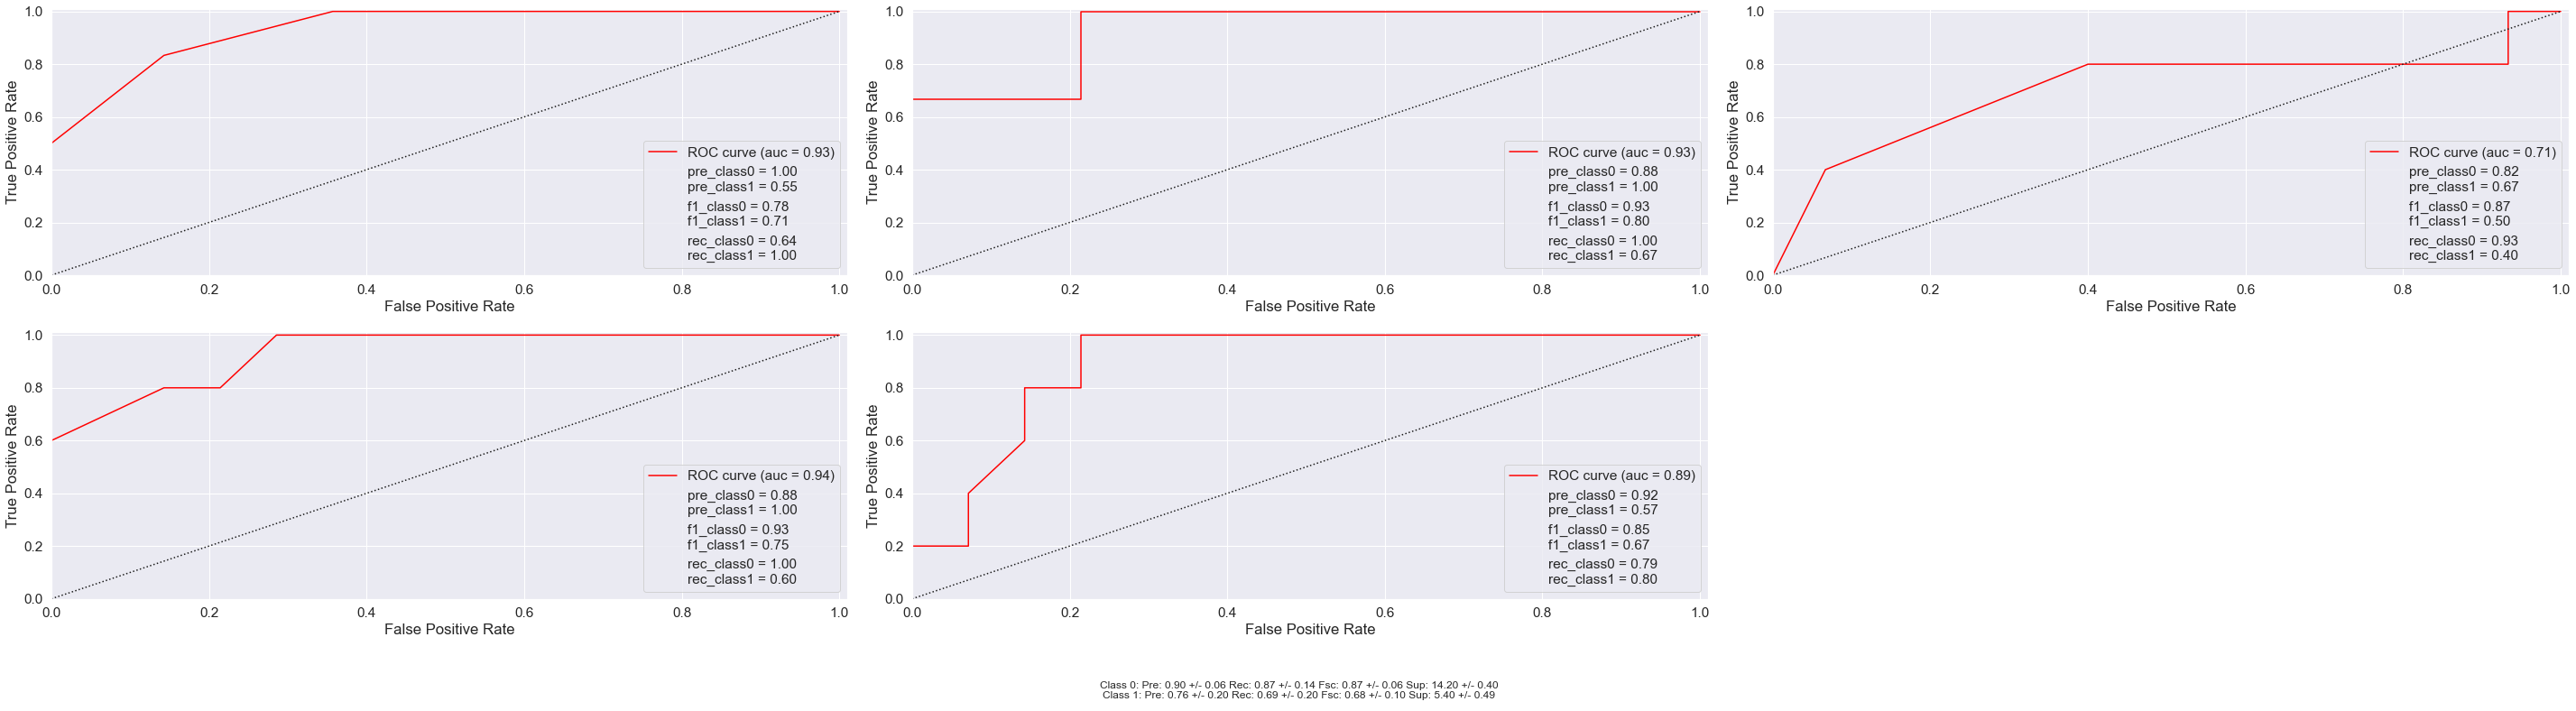

Setting penalty='none' will ignore the C and l1_ratio parameters
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Setting penalty='none' 

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' wi

Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters
Setting penalty='none' will ignore the C and l1_ratio parameters


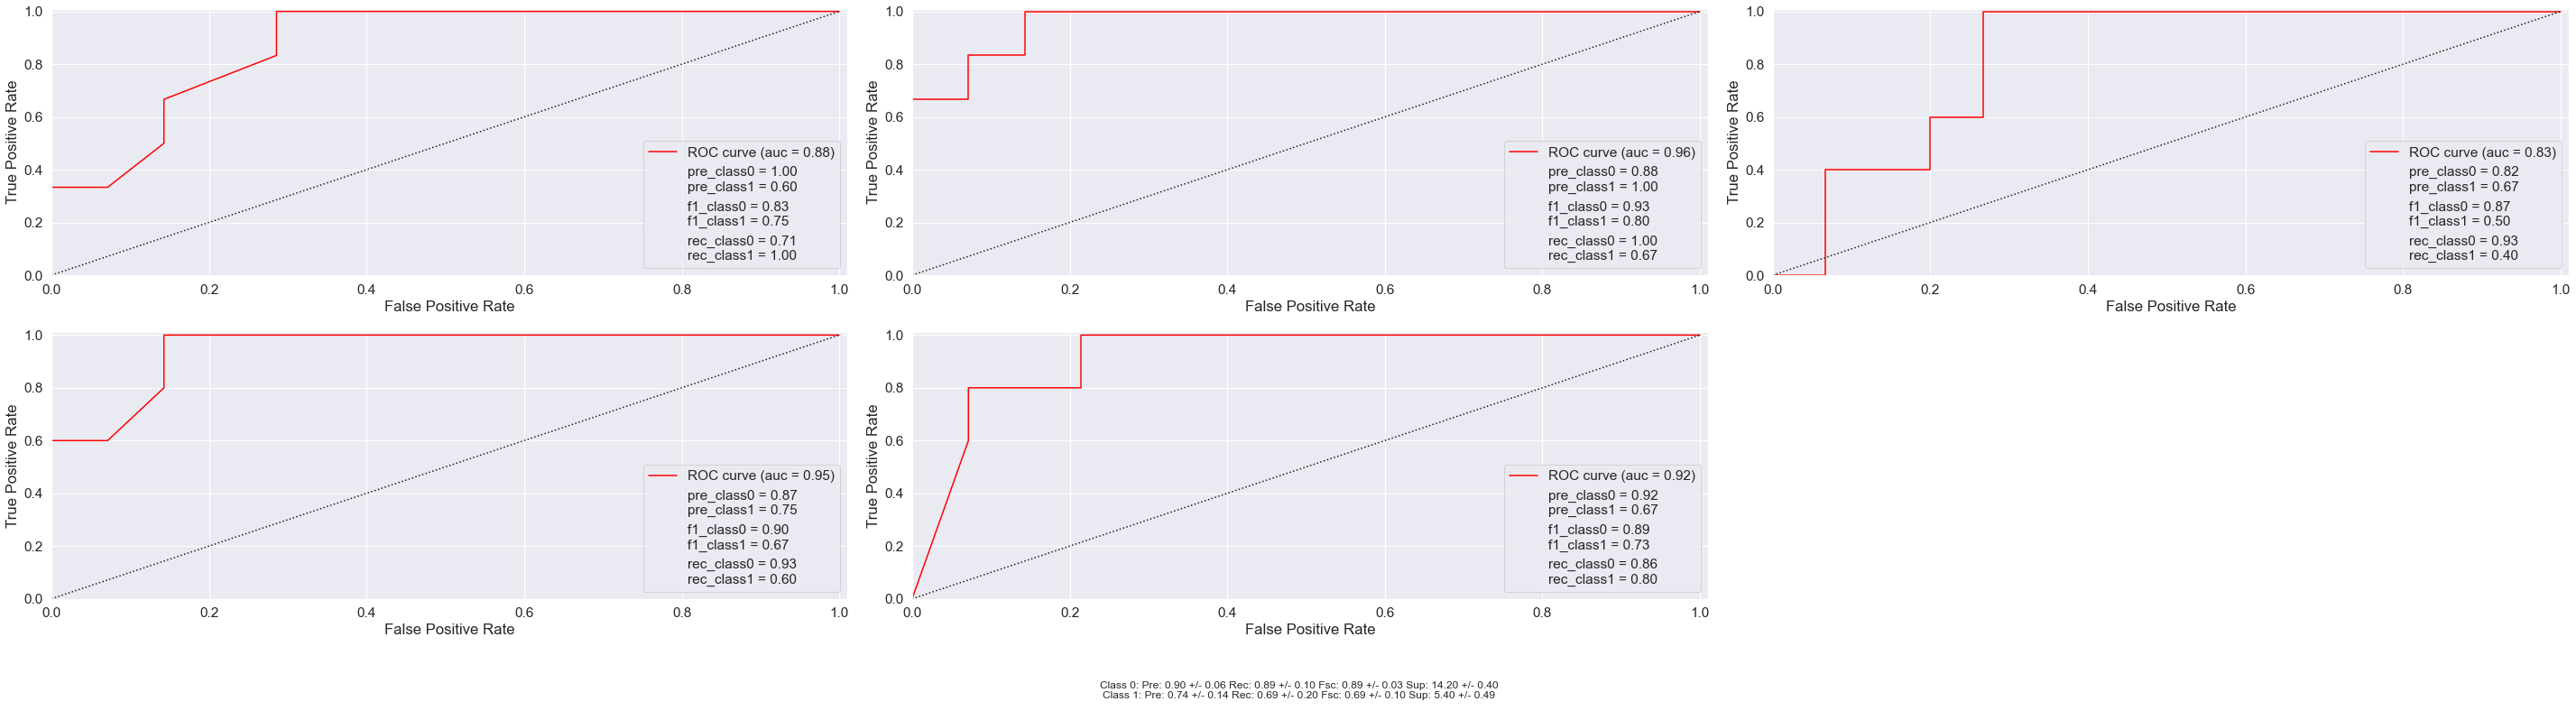

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the speci

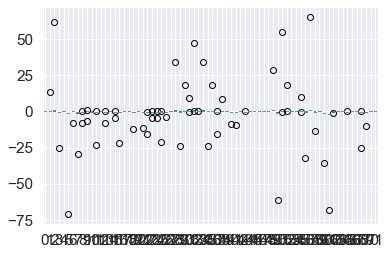

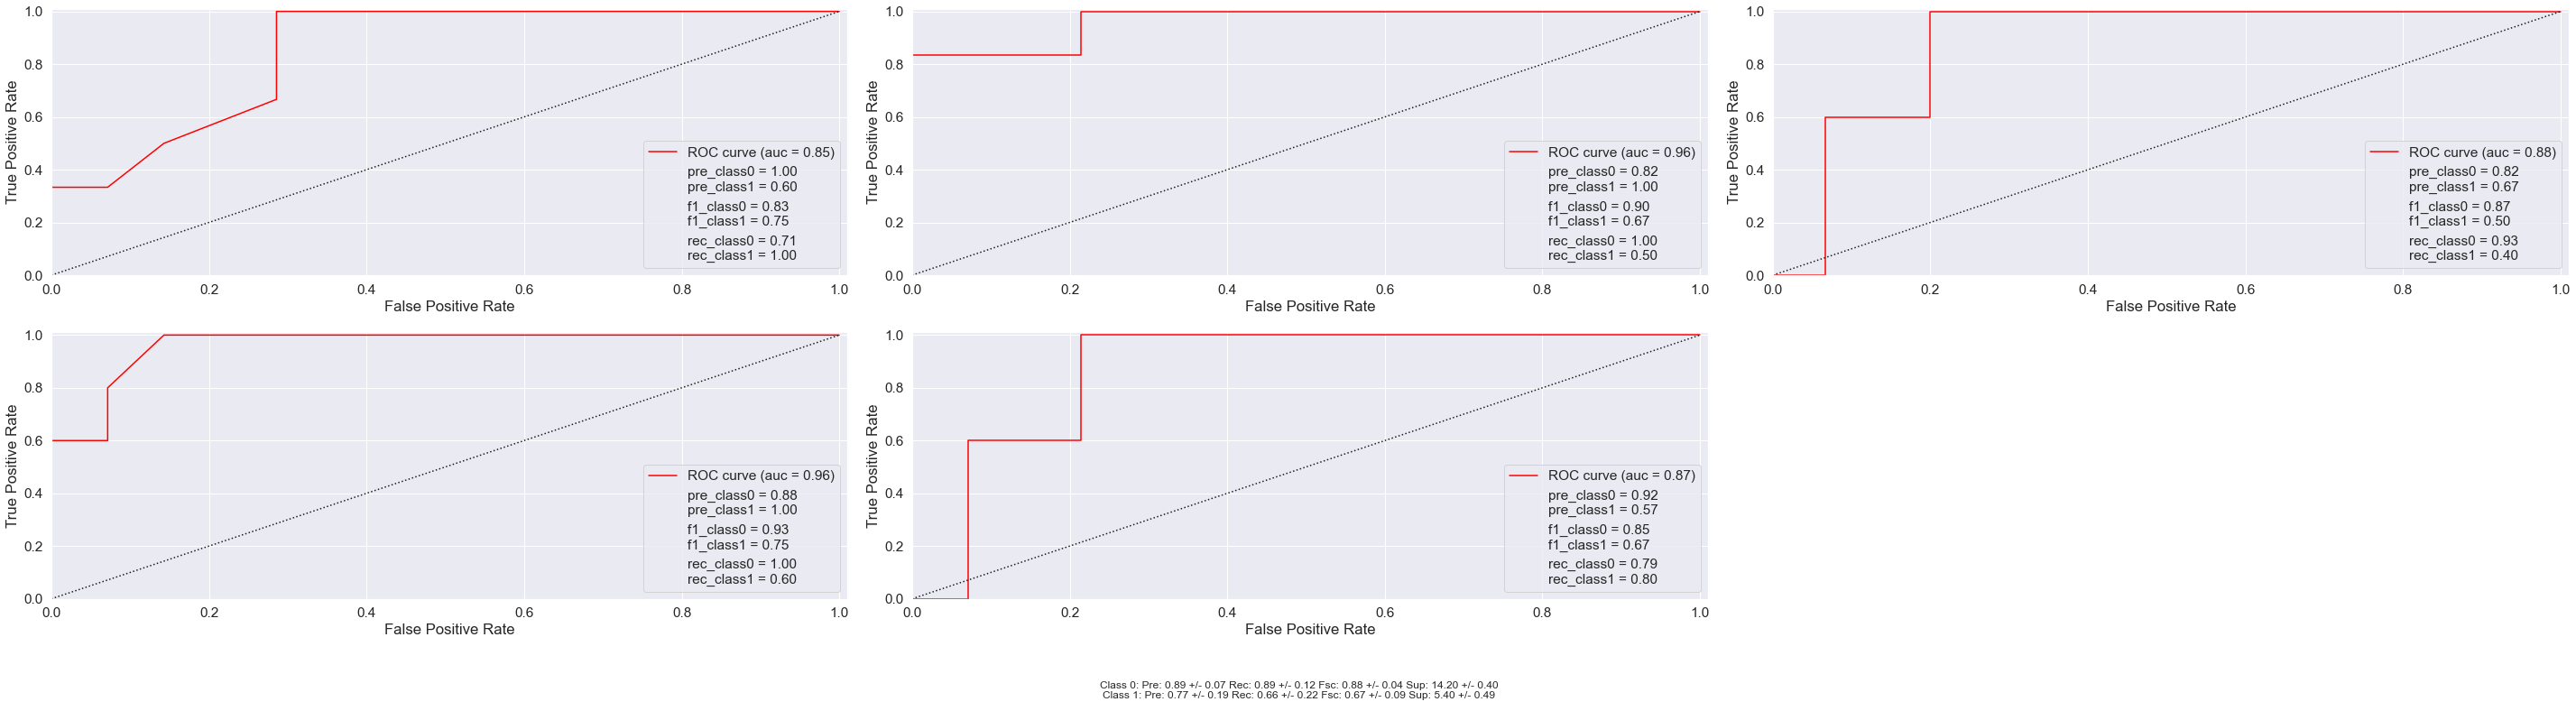

In [94]:
cwf.kfold_test_imbalenced_classifiers_with_optimization(features_df, classes_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=False, cv=10, n_repeats=5, smiles=smiles, names=names,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1),
                                                        smote=True)

In [95]:
kfold_clf_names = ["AdaBoost", "Logistic Regression", "Gaussian Process"]
directory_names = cwf.directory_names_from_classfier_names(kfold_clf_names)

# Analyse models

## Confusion matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

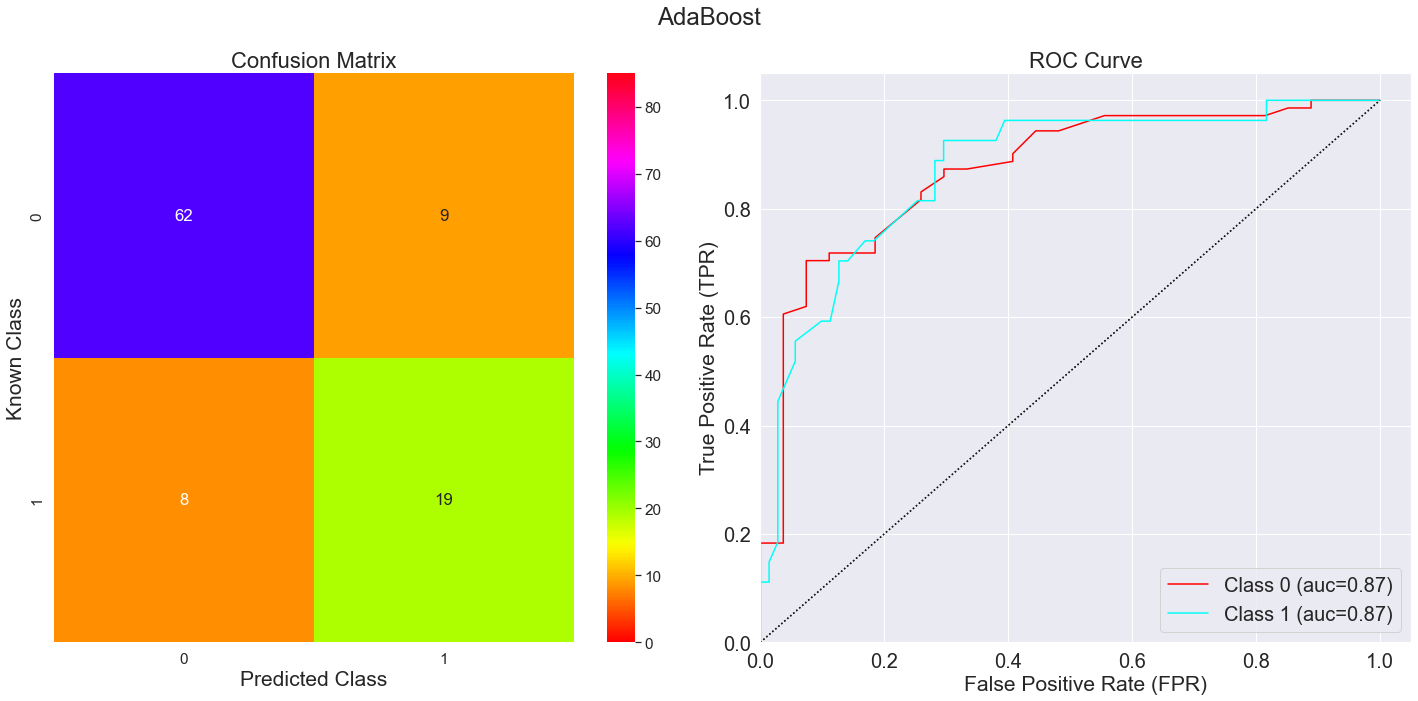

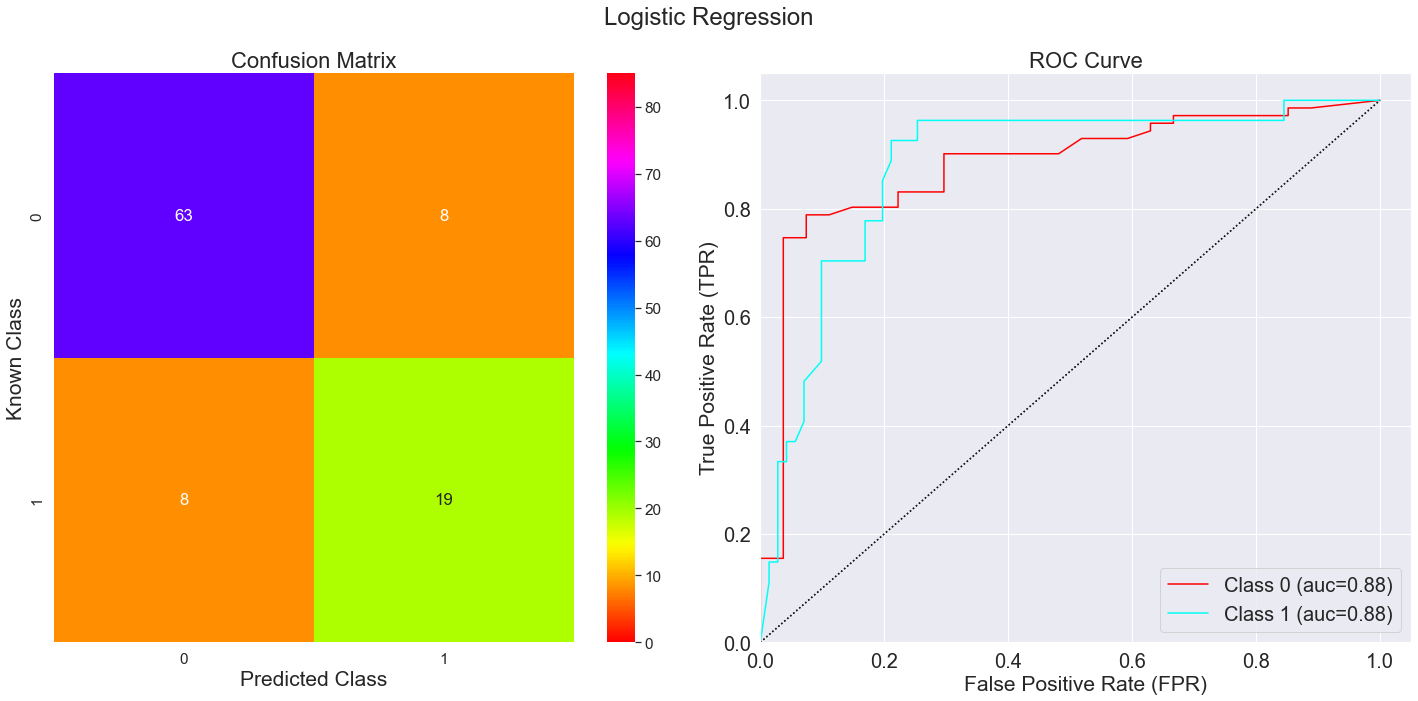

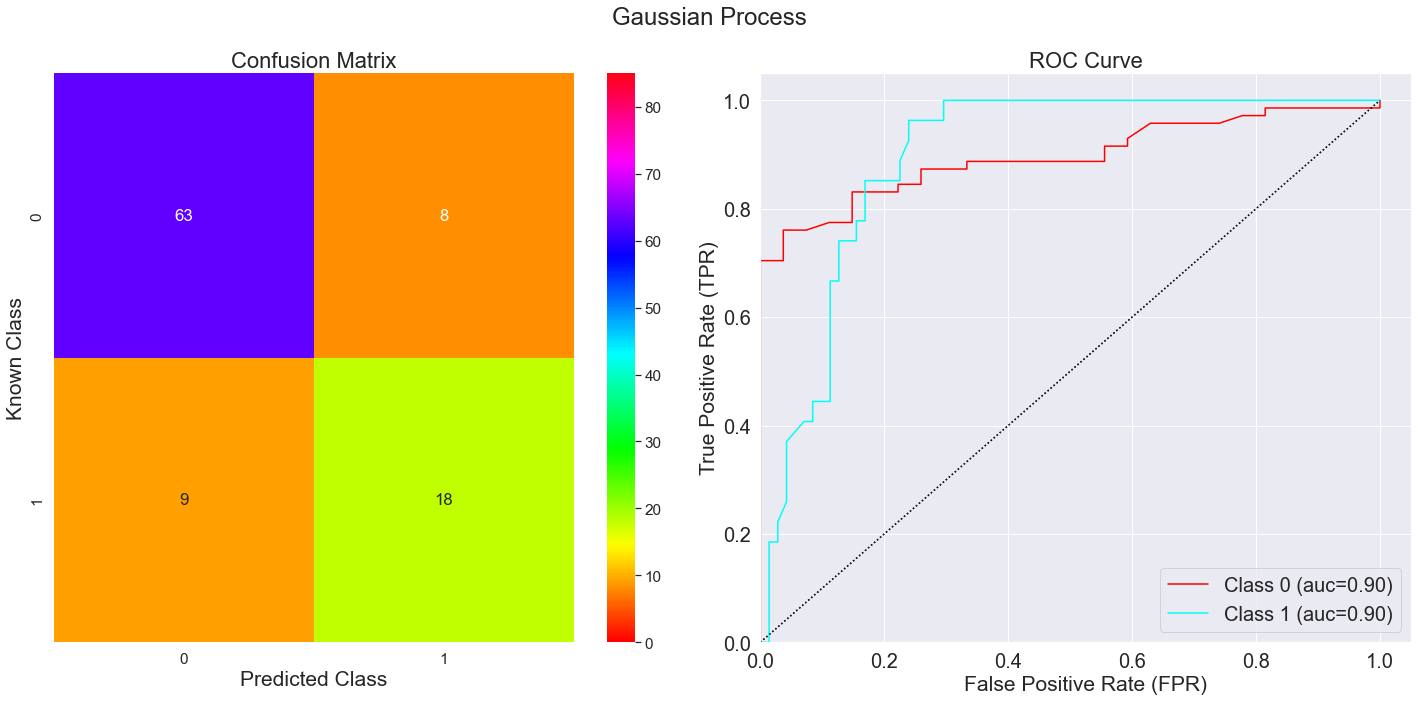

In [96]:
files_plt = []

kfold_clf_names = ["AdaBoost",
         "Logistic Regression", "Gaussian Process"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=5)
    data.to_csv("{}_cv_predictions.csv".format("_".join(dirname.split()), index=False))
    log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "capacity_{}_fingerprints.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="hsv", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]),)
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
        "accuracy": metrics["accuracy"],
        "sensitivity": metrics["tpr"],
        "specificity": metrics["tnr"],
        "mcc": metrics["matthews_correlation_coefficient"],

        }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("capacity_metrics_fingerprints.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for capacity with models built from fingerprint features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:fingerprint_features")
log.info(df_metrics_for_paper.to_latex())
    

## Feature importance

In [97]:
fimp = pd.read_csv("importance_lr.csv")

In [98]:
fimp_mean = fimp.mean(axis=0)
means = fimp_mean.values
fimp_means = pd.DataFrame(means).transpose()
fimp_means.columns=features_df.columns

fimp_sigma = fimp.std(axis=0)
sigmas = fimp_sigma.values
fimp_sigmas = pd.DataFrame(sigmas).transpose()
fimp_sigmas.columns=features_df.columns

In [99]:
fimp_means.iloc[0, :].values

array([  0.        ,   3.01034589,  12.92470571,  -5.40941466,
         0.        , -15.06684   ,  -1.56397731,  -6.4441867 ,
        -1.76264411,  -0.82159274,  -0.20054557,  -4.89860158,
         0.        ,  -1.76264411,   0.        ,  -0.93497482,
        -4.77425845,   0.        ,   0.        ,  -2.60490307,
         0.        ,  -2.34759152,  -3.28256634,  -0.93497482,
        -0.93497482,  -4.17105445,  -0.86717975,   0.        ,
         7.32319048,  -4.83557224,   4.08720101,   1.98828576,
         9.85882474,   0.26045695,   7.32319048,  -4.7252741 ,
         4.08720101,  -3.25549936,   1.8451379 ,   0.        ,
        -1.79995507,  -1.92748725,   0.        ,  -0.04440583,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   6.48674517, -12.92912849,  11.39500067,
         3.93963925,   0.        ,   0.        ,   2.11820402,
        -6.20203372,  13.90728263,  -2.74417511,   0.        ,
        -7.7972308 , -14.97658604,  -0.25761512,   0.  

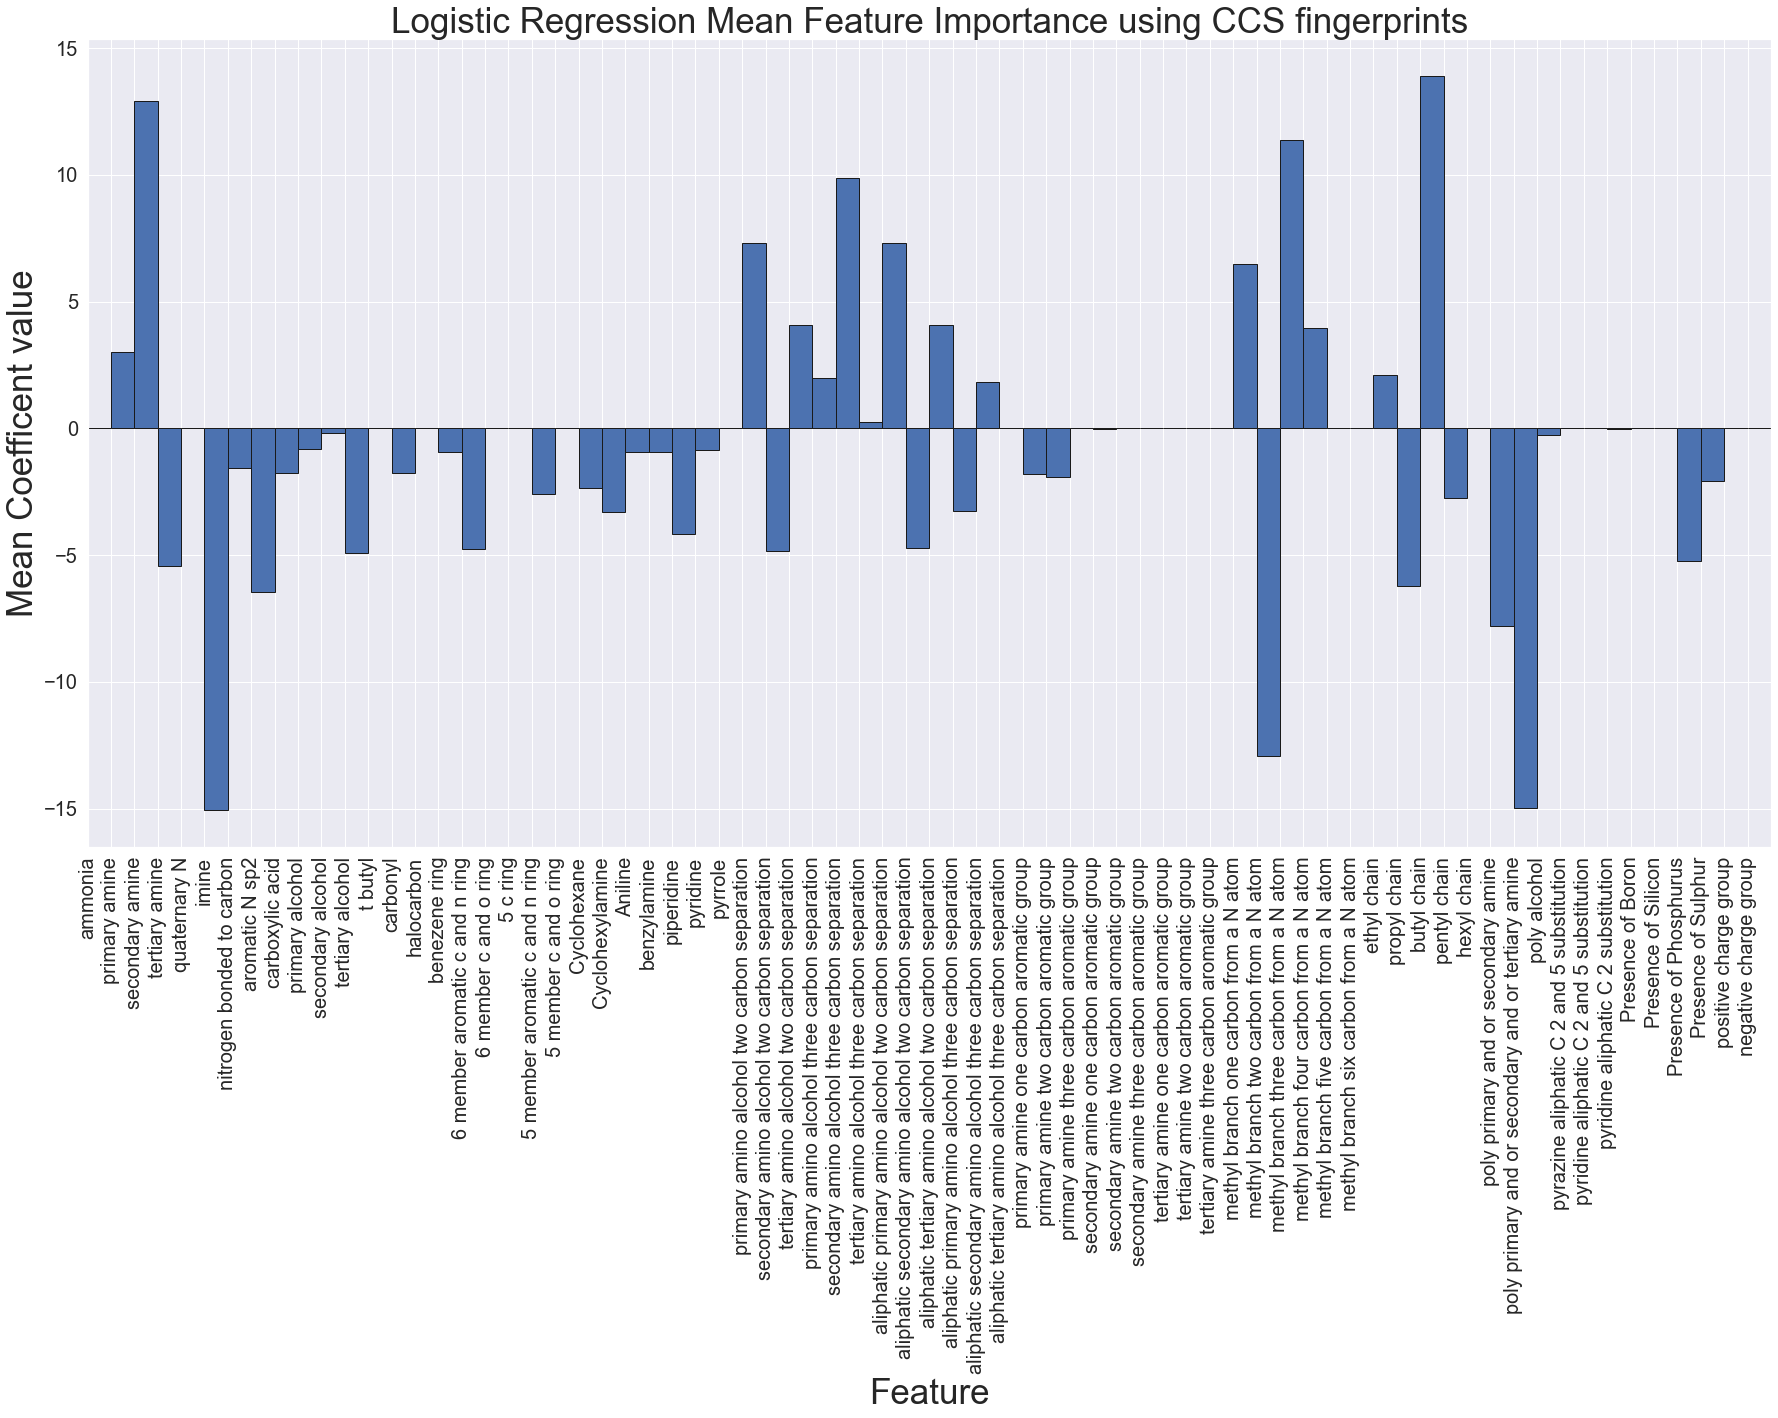

In [100]:
figure = plt.figure(figsize=(25,20))
plt.bar(x=[" ".join(ent.split("_")) for ent in fimp_means.columns], 
        height=fimp_means.iloc[0,:].values, 
        width=1.0,
        edgecolor="k",
        align="edge")
bins = np.arange(len(fimp_means.columns))
plt.xlim([0,bins.size])
plt.xlabel("Feature", fontsize=35)
plt.ylabel("Mean Coefficent value", fontsize=35)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Logistic Regression Mean Feature Importance using CCS fingerprints", fontsize=35)
plt.grid(True)
plt.tight_layout()
plt.savefig("feature_importance_lr_ccs.png")